# Importando e separando os conjuntos

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../Aula8/ripley.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
print(df.shape) 
df_treino = df.iloc[:750] 
df_val = df.iloc[750:1000] 
df_teste = df.iloc[1000:] 
x_treino, y_treino = df_treino.iloc[:, :-1].values, df_treino.iloc[:,-1].values
x_val, y_val = df_val.iloc[:, :-1].values, df_val.iloc[:,-1].values
x_teste, y_teste = df_teste.iloc[:, :-1].values, df_teste.iloc[:,-1].values

(1250, 3)


# Criando o Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class RipDados(Dataset):
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i].astype('float32'), self.y[i].astype('float32')

In [6]:
ds_treino = RipDados(x_treino, y_treino)
ds_val = RipDados(x_val, y_val)
ds_teste = RipDados(x_teste, y_teste)

In [7]:
dl_treino = DataLoader(ds_treino, batch_size=32, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=128)
dl_teste  = DataLoader(ds_teste, batch_size=128)

# Criando o modelo

In [8]:
import torch
from torch import nn

In [9]:
class Classificador(nn.Module):
    
    def __init__(self, n, l, c):
        super().__init__()
        self.rede = nn.Sequential(*[
            nn.Linear(n, l),
            nn.ReLU(),
            nn.Linear(l, c),
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        return self.rede(x).squeeze()

In [10]:
model = Classificador(2, 32, 1)

In [11]:
model

Classificador(
  (rede): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Definindo a funcao de custo e otimizador

In [12]:
loss_fn = nn.MSELoss()

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Treinando

In [14]:
def loader_loss(data_loader):
    model.eval()
    loss = []
    for x, y in data_loader:
        o = model(x)
        loss += [loss_fn(o, y)]
    return sum(loss)/len(loss)

In [15]:
loss_epoch_treino = []
loss_epoch_validacao = []
for _ in range(15):
    loss_treino_tracker = []
    for x, y in dl_treino:
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        loss_treino_tracker += [loss]
      
    loss_epoch_validacao.append(loader_loss(dl_val))
    loss_epoch_treino.append(sum(loss_treino_tracker)/len(loss_treino_tracker))

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,0,'Épocas')

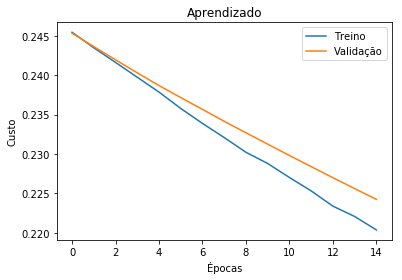

In [17]:
plt.plot(loss_epoch_treino)
plt.plot(loss_epoch_validacao)
plt.legend(['Treino', 'Validação'])
plt.title('Aprendizado')
plt.ylabel('Custo')
plt.xlabel('Épocas')